In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Neural Network - With Target Encoded Feature
Neural network plus the mean encoded feature

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_combined_scaled_all.parquet'))

In [9]:
with open(Path(setup.temp_path).joinpath('20_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [10]:
features = [f for f in imputer_features if 'NAICS' not in f]
features = features + ['menc_NAICS']
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag', 'menc_NAICS']


##### Datasets for train, validation

In [11]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [12]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (436120, 11), y:(436120,)


In [13]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (93454, 11), y:(93454,)


In [14]:
base_thresh = y_train.mean()
print(base_thresh)

0.2046546821975603


## Function to create model

In [15]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [16]:
this_model = create_model()

2024-03-28 22:16:45.540178: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-28 22:16:45.540208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-28 22:16:45.540214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-28 22:16:45.540675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 22:16:45.541081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9857 (38.50 KB)
Trainable params: 9857 (38.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-03-28 22:16:46.292185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - ETA: 0s - loss: 0.4664 - auc: 0.3364 - auc_1: 0.6970

2024-03-28 22:20:29.347809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - 252s 18ms/step - loss: 0.4664 - auc: 0.3364 - auc_1: 0.6970 - val_loss: 0.4629 - val_auc: 0.3615 - val_auc_1: 0.7106
Epoch 2/20
13629/13629 [==============================] - 248s 18ms/step - loss: 0.4584 - auc: 0.3586 - auc_1: 0.7140 - val_loss: 0.4604 - val_auc: 0.3695 - val_auc_1: 0.7160
Epoch 3/20
13629/13629 [==============================] - 250s 18ms/step - loss: 0.4569 - auc: 0.3632 - auc_1: 0.7170 - val_loss: 0.4608 - val_auc: 0.3723 - val_auc_1: 0.7187
Epoch 4/20
13629/13629 [==============================] - 178s 13ms/step - loss: 0.4563 - auc: 0.3656 - auc_1: 0.7182 - val_loss: 0.4595 - val_auc: 0.3738 - val_auc_1: 0.7190
Epoch 5/20
13629/13629 [==============================] - 169s 12ms/step - loss: 0.4560 - auc: 0.3669 - auc_1: 0.7190 - val_loss: 0.4593 - val_auc: 0.3738 - val_auc_1: 0.7193
Epoch 6/20
13629/13629 [==============================] - 174s 13ms/step - loss: 0.4556 - auc: 0.3671 - auc_1: 0.7197 - val_loss: 0.4599

In [19]:
this_history_df = pd.DataFrame(this_history.history)

In [20]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [21]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [22]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('23_REPORT_fit_history.csv'))

<Axes: >

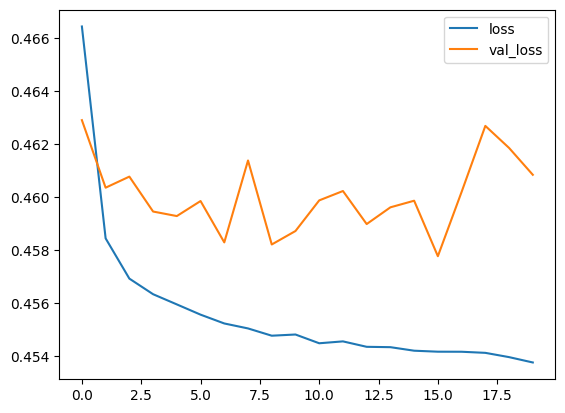

In [23]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

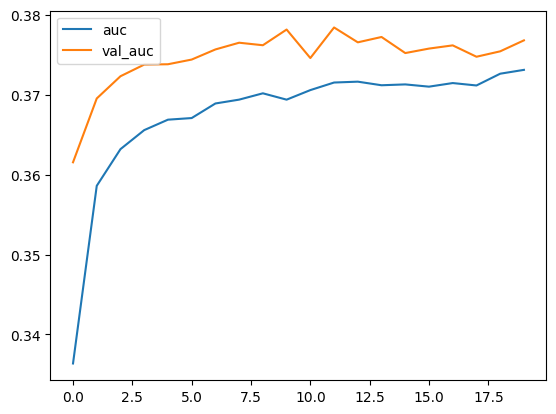

In [24]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

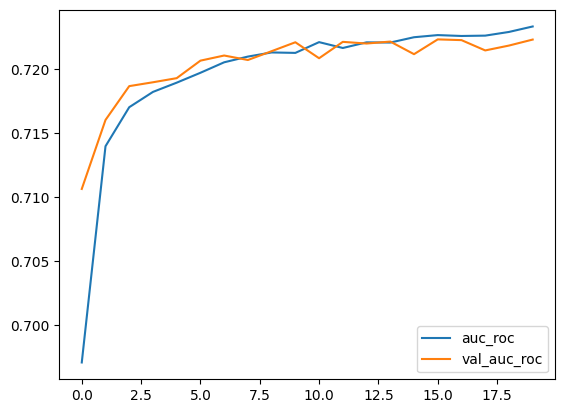

In [25]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [26]:
this_model.save(Path(setup.temp_path).joinpath('23_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [27]:
all_predictions = this_model.predict(X.drop(columns='dset'))

  117/21503 [..............................] - ETA: 27s

2024-03-29 00:43:05.070817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 26s 1ms/step


In [28]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [29]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.315101
target,0.315101,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [30]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [31]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [32]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.448898
10,0.20,0.448376
8,0.16,0.445598


In [33]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [34]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [35]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.541542
1    0.458458
Name: proportion, dtype: float64

In [36]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('23_DATA_predictions.parquet'))

## Metrics

In [37]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('23_DATA_predictions.parquet'))

In [38]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('23_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.629367,0.435506,0.310319,0.729996,0.362163,0.724914,NaN
1,train,0.634990,0.448898,0.324815,0.726388,0.380671,0.727427,NaN
2,val,0.632653,0.448230,0.325581,0.719134,0.376875,0.722401,NaN
0,test,0.632690,0.447950,0.324200,0.724497,0.376685,0.724844,0.0
1,test,0.624593,0.417035,0.290489,0.738939,0.341251,0.725387,1.0


## Embeddings
Save the hidden layer weight prior to sigmoid output, for possible later use in unsupervised GNN 

In [39]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.layers[-2].output) 

In [40]:
embed_out = embed_model.predict(X.drop(columns='dset'))

  187/21503 [..............................] - ETA: 17s

2024-03-29 00:43:51.171577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 17s 802us/step


In [41]:
embed_out.shape

(688081, 64)

In [42]:
embed_df = pd.DataFrame(embed_out, index=X.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [43]:
embed_df.head()

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_054,emb_055,emb_056,emb_057,emb_058,emb_059,emb_060,emb_061,emb_062,emb_063
0,1000014003,0.999997,-0.185493,0.778988,0.999991,-1.000000,0.058228,-0.999978,-0.427396,0.351970,...,0.577731,-1.000000,-0.999999,0.883864,0.855696,-0.352030,-0.999815,1.0,0.999773,0.999999
1,1000024006,0.999988,0.156657,0.977533,0.999999,-1.000000,0.979082,-0.999991,-0.969789,-0.513925,...,-0.656893,-1.000000,-0.999985,0.998748,0.955726,0.141398,-0.999807,1.0,0.999900,0.999999
2,1000034009,0.999998,-0.455601,0.968171,0.475721,-0.999759,0.998743,-0.999965,-0.916335,0.151704,...,-0.590935,-0.999942,-0.999999,0.999960,0.952065,-0.222828,-0.999999,1.0,0.999772,0.615164
3,1000084002,0.999999,-0.584501,0.894935,0.050126,-0.999244,0.993820,-0.999929,-0.585380,0.448615,...,-0.165131,-0.999978,-1.000000,0.999703,0.945566,-0.459805,-1.000000,1.0,0.999757,0.447167
4,1000094005,0.999978,0.155097,0.991113,0.999997,-1.000000,0.988084,-0.999998,-0.978370,-0.442554,...,-0.695188,-1.000000,-0.999988,0.999535,0.958219,0.319526,-0.999871,1.0,0.999939,0.999997


In [44]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('23_DATA_embeddings.parquet'))